In [1]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC

np.random.seed(0)

import os
os.add_dll_directory('C:\Aorda\PSG\lib')
import psgpython as psg
from psgutilities import *

In [2]:
def gen_data():
  # Define coordinates for the vertices of the triangle
  vertices = np.array([[-6, 0], [6, 0], [0, 10]])

  numPointsPerCluster = 250

  # Class -1: Generate data points in the first cluster (triangle vertex 1)
  mean_class_minus = vertices[0]
  cov_class_minus = [[1, 0], [0, 1]]
  class_minus = np.random.multivariate_normal(mean_class_minus, cov_class_minus, numPointsPerCluster)

  # Class 0: Generate data points in the second cluster (triangle vertex 2)
  mean_class_zero = vertices[1]
  cov_class_zero = [[1, 0], [0, 1]]
  class_zero = np.random.multivariate_normal(mean_class_zero, cov_class_zero, numPointsPerCluster)

  # Class +1: Generate data points in the third cluster (triangle vertex 3)
  mean_class_plus = vertices[2]
  cov_class_plus = [[1, 0], [0, 1]]
  class_plus = np.random.multivariate_normal(mean_class_plus, cov_class_plus, numPointsPerCluster)

  # Combine the three clusters and shuffle
  X1 = np.vstack((class_minus, class_zero, class_plus))
  # Assign labels: 0 and 2 as -1, 1 as +1
  y1 = np.where(np.isin(X1, class_minus).all(axis=1) | np.isin(X1, class_plus).all(axis=1), -1, 1)

  # store for cluster coloring purpose
  labels_cluster1 = np.ones(numPointsPerCluster)
  labels_cluster2 = 2 * np.ones(numPointsPerCluster)
  labels_cluster3 = 3 * np.ones(numPointsPerCluster)
  origX = X1
  colorX = np.hstack((labels_cluster1, labels_cluster2, labels_cluster3))

  # Shuffle the dataset
  shuffle_idx = np.arange(len(X1))
  np.random.shuffle(shuffle_idx)
  X1 = X1[shuffle_idx]
  y1 = y1[shuffle_idx]

  # Create a separate dataset with modified labels
  X2 = np.vstack((class_minus, class_zero, class_plus))
  # Assign labels: 1 and 2 as +1, 0 as -1
  y2 = np.where(np.isin(X2, class_zero).all(axis=1) | np.isin(X2, class_plus).all(axis=1), 1, -1)

  # Shuffle the dataset
  shuffle_idx = np.arange(len(X2))
  np.random.shuffle(shuffle_idx)
  X2 = X2[shuffle_idx]
  y2 = y2[shuffle_idx]

  # Return the datasets
  return [X1, X2], [y1, y2], [origX, colorX]

In [3]:
def min_bpoe(X, y, a, initial_w=None):
  # multiply each y1 vector a1 scalar (etc. for y2, a2)
  y = [y[i] * a[i] for i in range(DIMS)]
  # Combine X columns into one matrix
  X = np.hstack((X[i] for i in range(DIMS)))
  # add column of 1s to X matrix
  extra_column = np.ones((len(X), DIMS))
  X = np.hstack((X, extra_column))

  # multiply each of the y columns by the respective X columns
  cols_to_multiply1 = X[:, [0, 1, 4]]
  cols_to_multiply2 = X[:, [2, 3, 5]]

  result1 = cols_to_multiply1 * y[0].reshape(-1, 1)
  result2 = cols_to_multiply2 * y[1].reshape(-1, 1)

  bpoe_matrix_scenarios_body = np.hstack((result1, result2))

  # add benchmark column
  bpoe_scenario_benchmark = np.array([a @ x] * len(X))
  bpoe_matrix_scenarios_body = np.column_stack((bpoe_matrix_scenarios_body, bpoe_scenario_benchmark))
  bpoe_matrix_scenarios_body = np.asarray(bpoe_matrix_scenarios_body, order='C')

  bpoe_header = ['w11', 'w12', 'b1', 'w21', 'w22', 'b2']
  bpoe_matrix_scenarios = [bpoe_header+['scenario_benchmark'], bpoe_matrix_scenarios_body]

  bpoe_matrix_quadratic1_body = np.asarray([[1, 0, 0, 0, 0, 0],
                                            [0, 1, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0]], order='C')
  bpoe_matrix_quadratic2_body = np.asarray([[0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, 0, 0, 1, 0, 0],
                                            [0, 0, 0, 0, 1, 0],
                                            [0, 0, 0, 0, 0, 0]], order='C')
  bpoe_matrix_quadratic1 = [bpoe_header, bpoe_matrix_quadratic1_body]
  bpoe_matrix_quadratic2 = [bpoe_header, bpoe_matrix_quadratic2_body]

  allowExternal = True
  suppressMessages = False
  bpoe_problem_name = "problem_classify"
  bpoe_problem_statement = f"minimize\n\
  bpoe({0},matrix_scenarios)\n\
  Constraint: <= 1\n\
  quadratic(matrix_quadratic1)\n\
  Constraint: <= 1\n\
  quadratic(matrix_quadratic2)\n\
  Box: >= -10, <= 10\n\
  Solver: VAN"
  bpoe_problem_dictionary = {'problem_name':bpoe_problem_name, 
                             'problem_statement':bpoe_problem_statement, 
                             'matrix_scenarios':bpoe_matrix_scenarios, 
                             'matrix_quadratic1':bpoe_matrix_quadratic1, 
                             'matrix_quadratic2':bpoe_matrix_quadratic2}
  # if an initial point estimate is provided use it
  if(initial_w is not None):
    bpoe_problem_statement = f"minimize\n\
    bpoe({0},matrix_scenarios)\n\
    Constraint: <= 1\n\
    quadratic(matrix_quadratic1)\n\
    Constraint: <= 1\n\
    quadratic(matrix_quadratic2)\n\
    Box: >= -10, <= 10\n\
    Solver: VAN, init_point = point_initial_w"
    bpoe_problem_dictionary['point_initial_w'] = [bpoe_header, np.asarray(initial_w, order='C')]

  bpoe_res = psg.psg_solver(bpoe_problem_dictionary, allowExternal, suppressMessages)
  print(f"{bpoe_problem_name} Result:\n{bpoe_res}")
  print(f"{bpoe_problem_name} Optimal Point:\n{get_optimalpoint(bpoe_res)}")
  print(f"{bpoe_problem_name} Objective:\n{get_objective(bpoe_res)}")

  return (get_optimalpoint(bpoe_res), get_objective(bpoe_res))

In [4]:
def min_pm(X, y, w, initial_a=None):
  # unpack
  w11, w12, b1, w21, w22, b2 = w
  X1, X2 = X
  y1, y2 = y

  # multiply columns of X by their respective w_ij, sum the columns horizontally, and add b_j
  X1[:, 0] *= w11
  X1[:, 1] *= w12
  X1 = np.sum(X1, axis=1) + b1
  X1 = x[0] - (y1 * X1)

  X2[:, 0] *= w21
  X2[:, 1] *= w22
  X2 = np.sum(X2, axis=1) + b2
  X2 = x[1] - (y2 * X2)

  pm_matrix_scenarios_body = np.column_stack((X1, X2))
  pm_matrix_scenarios_body = np.asarray(pm_matrix_scenarios_body, order='C')
  pm_header = ['a1', 'a2']
  pm_matrix_scenarios = [pm_header, pm_matrix_scenarios_body]
  pm_matrix_linear_body = np.asarray([1, 1], order='C')
  pm_matrix_linear = [pm_header, pm_matrix_linear_body]

  allowExternal = True
  suppressMessages = False
  pm_problem_name = "problem_classify"
  pm_problem_statement = f"minimize\n\
  pm_pen({-1},matrix_scenarios)\n\
  Constraint: == 2\n\
  linear(matrix_linear)\n\
  Box: >= 0\n\
  Solver: CAR"
  pm_problem_dictionary = {'problem_name':pm_problem_name, 
                             'problem_statement':pm_problem_statement, 
                             'matrix_scenarios':pm_matrix_scenarios,
                             'matrix_linear':pm_matrix_linear}
  # if initial point estimate is provided use it
  if(initial_a is not None):
    pm_problem_statement = f"minimize\n\
    pm_pen({-1},matrix_scenarios)\n\
    Constraint: == 2\n\
    linear(matrix_linear)\n\
    Box: >= 0\n\
    Solver: CAR, init_point = point_initial_a"
    pm_problem_dictionary['point_initial_a'] = [pm_header, np.asarray(initial_a, order='C')]

  pm_res = psg.psg_solver(pm_problem_dictionary, allowExternal, suppressMessages)
  print(f"{pm_problem_name} Result:\n{pm_res}")
  print(f"{pm_problem_name} Optimal Point:\n{get_optimalpoint(pm_res)}")
  print(f"{pm_problem_name} Objective:\n{get_objective(pm_res)}")

  return (get_optimalpoint(pm_res), get_objective(pm_res))

  

In [5]:
def driver():
  X, y, colors = gen_data()

  # step 2
  bpoe_opt_point, bpoe_obj = min_bpoe(np.copy(X), np.copy(y), a)
  w_tilda = bpoe_opt_point[1]
  # step 3
  pm_opt_point, pm_obj = min_pm(np.copy(X), np.copy(y), w_tilda)
  a_tilda = pm_opt_point[1]

  a1, a2 = a_tilda
  w11, w12, b1, w21, w22, b2 = w_tilda

  p_tilda = pm_obj
  print('p tilda:')
  print(p_tilda)

  w_star = w_tilda
  a_star = a
  while(True):
    bpoe_opt_point, bpoe_obj = min_bpoe(np.copy(X), np.copy(y), a_tilda, initial_w = w_tilda)
    w_star = bpoe_opt_point[1]
    pm_opt_point, pm_obj = min_pm(np.copy(X), np.copy(y), w_star, initial_a = a_tilda)
    a_star = pm_opt_point[1]

    w11, w12, b1, w21, w22, b2 = w_star

    p_star = pm_obj
    print('p star:')
    print(p_star)

    if(p_tilda - p_star < epsilon):
      break
      
    w_tilda, a_tilda, p_tilda = w_star, a_star, p_star
  
  return p_tilda, p_star, w_tilda, w_star, a_tilda, a_star, X, y, colors


In [9]:
# Constants / vectors
DIMS = 2
a = np.array([1] * DIMS) # initial vector
epsilon = 0.1 # error allowance
# as clusters are further apart, x val should get larger and vice versa for closer together cluster
# too small val (<=0) causes 'explosion' to one line only
# too large value and the lines over-distance themselves from clusters
x = np.array([4] * DIMS)

C:\Users\jacob\AppData\Local\Temp\ipykernel_20112\3556585319.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X = np.hstack((X[i] for i in range(DIMS)))


Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=33  Objective=-.146478689563E+01  Residual=0.000000000000E+00
Start stage  1
Ext.iteration=0  Objective=-.507527378343E-16  Residual=0.000000000000E+00
Ext.iteration=39  Objective=-.302551641380E+00  Residual=0.373923114694E-11
Start stage  2
Ext.iteration=0  Objective=-.108120193022E-15  Residual=0.373923114694E-11
Ext.iteration=33  Objective=-.222582872922E-01  Residual=0.000000000000E+00
Start stage  3
Ext.iteration=0  Objective=-.661928311666E-16  Residual=0.000000000000E+00
Ext.iteration=24  Objective=-.287131515030E-03  Residual=0.193182046360E-06
Start stage  4
Ext.iteration=0  Objective=-.562319683300E-16  Residual=0.193182046360E-06
Ext.iteration=22 

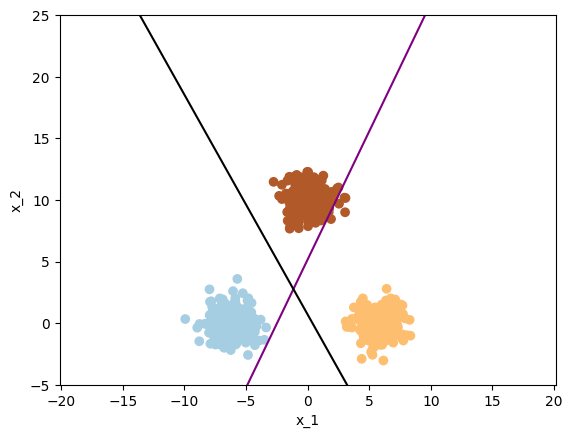

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=33  Objective=-.132894482227E+01  Residual=0.355271367880E-14
Start stage  1
Ext.iteration=0  Objective=-.133622928185E-15  Residual=0.355271367880E-14
Ext.iteration=29  Objective=-.158980421117E+00  Residual=0.271249689376E-11
Start stage  2
Ext.iteration=0  Objective=0.426181119375E-15  Residual=0.271249689376E-11
Ext.iteration=26  Objective=-.424919427565E-02  Residual=0.348465976074E-06
Start stage  3
Ext.iteration=0  Objective=0.222736458109E-15  Residual=0.348465976074E-06
Ext.iteration=21  Objective=0.222736458109E-15  Residual=0.348465976074E-06
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = 0.128992612232 [0.0000000000

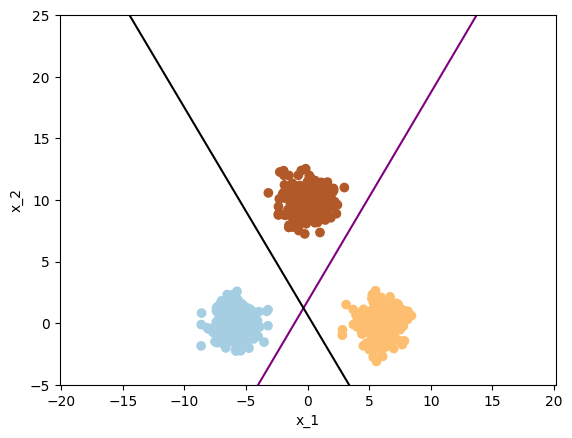

Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=32  Objective=-.142140084090E+01  Residual=0.355271367880E-14
Start stage  1
Ext.iteration=0  Objective=-.153653998234E-15  Residual=0.355271367880E-14
Ext.iteration=35  Objective=-.185050641489E+00  Residual=0.355271367880E-14
Start stage  2
Ext.iteration=0  Objective=0.262583501270E-15  Residual=0.355271367880E-14
Ext.iteration=42  Objective=-.515738930984E-02  Residual=0.254289744817E-08
Start stage  3
Ext.iteration=0  Objective=0.200468432897E-15  Residual=0.254289744817E-08
Ext.iteration=24  Objective=-.554343679969E-04  Residual=0.794675649729E-07
Start stage  4
Ext.iteration=0  Objective=-.248226814587E-15  Residual=0.794675649729E-07
Ext.iteration=32 

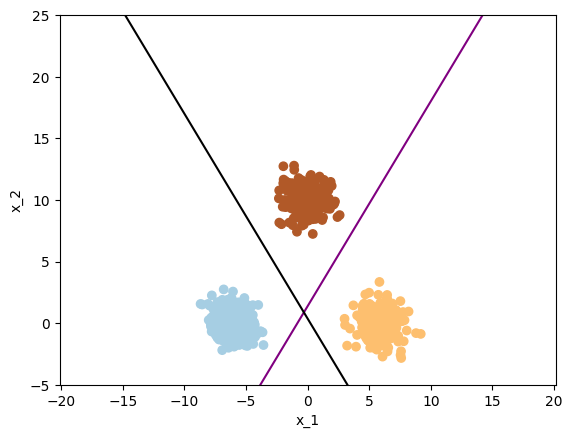

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=36  Objective=-.138977782452E+01  Residual=0.532907051820E-12
Start stage  1
Ext.iteration=0  Objective=-.826659398785E-16  Residual=0.532907051820E-12
Ext.iteration=23  Objective=-.168050716564E+00  Residual=0.741467902188E-06
Start stage  2
Ext.iteration=0  Objective=-.239726751531E-16  Residual=0.741467902188E-06
Ext.iteration=31  Objective=-.854967381825E-03  Residual=0.316546788781E-11
Start stage  3
Ext.iteration=0  Objective=0.297637060391E-16  Residual=0.316546788781E-11
Ext.iteration=31  Objective=-.220035152154E-05  Residual=0.569144731344E-11
Start stage  4
Ext.iteration=0  Objective=-.118095090428E-15  Residual=0.569144731344E-11
Ext.iteration=20  Objective=-.118095090428E-15  Residu

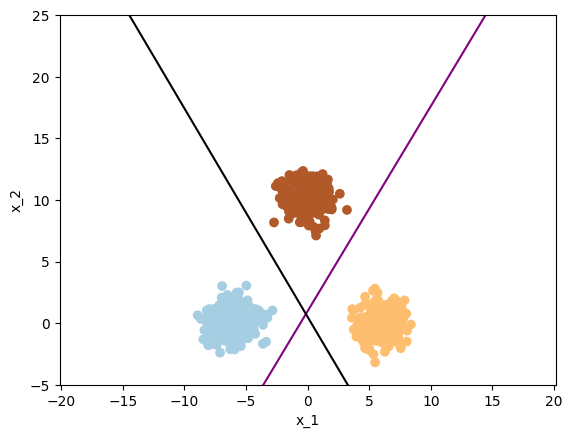

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=44  Objective=-.156794812559E+01  Residual=0.127442412179E-08
Start stage  1
Ext.iteration=0  Objective=-.220623749080E-15  Residual=0.127442412179E-08
Ext.iteration=32  Objective=-.310207766315E+00  Residual=0.000000000000E+00
Start stage  2
Ext.iteration=0  Objective=0.184627590053E-15  Residual=0.000000000000E+00
Ext.iteration=21  Objective=-.433675691838E-02  Residual=0.126121335597E-12
Start stage  3
Ext.iteration=0  Objective=-.165970424442E-15  Residual=0.126121335597E-12
Ext.iteration=23  Objective=0.316087401532E-13  Residual=0.177635683940E-14
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = 9.112840650382E-02 [0.000000

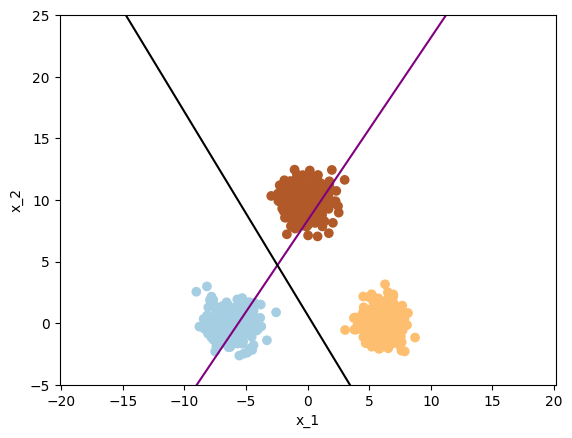

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=54  Objective=-.147614795379E+01  Residual=0.576960701437E-11
Start stage  1
Ext.iteration=0  Objective=0.198458851256E-15  Residual=0.576960701437E-11
Ext.iteration=33  Objective=-.301105724742E+00  Residual=0.000000000000E+00
Start stage  2
Ext.iteration=0  Objective=0.932048306944E-16  Residual=0.000000000000E+00
Ext.iteration=24  Objective=-.925663118550E-02  Residual=0.000000000000E+00
Start stage  3
Ext.iteration=0  Objective=-.130115621519E-15  Residual=0.000000000000E+00
Ext.iteration=25  Objective=-.289982929535E-03  Residual=-.355271367880E-14
Start stage  4
Ext.iteration=0  Objective=-.342437943914E-15  Residual=-.355271367880E-14
Ext.iteration=21  Objective=-.342437943914E-15  Residu

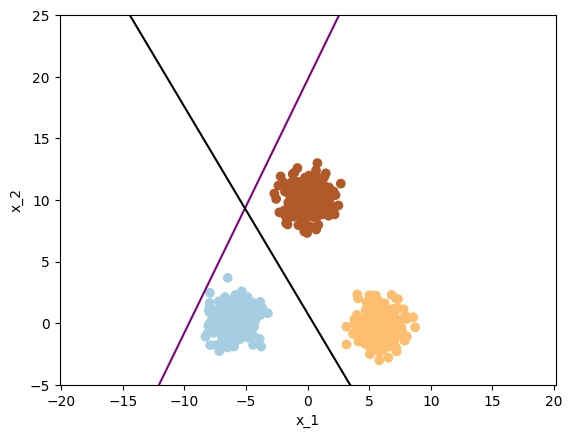

Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=33  Objective=-.132493518866E+01  Residual=0.355271367880E-14
Start stage  1
Ext.iteration=0  Objective=-.112681812485E-15  Residual=0.355271367880E-14
Ext.iteration=31  Objective=-.196625741406E+00  Residual=0.177635683940E-14
Start stage  2
Ext.iteration=0  Objective=0.152298864042E-15  Residual=0.177635683940E-14
Ext.iteration=22  Objective=-.956185332410E-03  Residual=0.299111611923E-06
Start stage  3
Ext.iteration=0  Objective=0.139997118820E-15  Residual=0.299111611923E-06
Ext.iteration=23  Objective=-.278022838899E-05  Residual=0.355271367880E-14
Start stage  4
Ext.iteration=0  Objective=0.270066569709E-15  Residual=0.355271367880E-14
Ext.iteration=24 

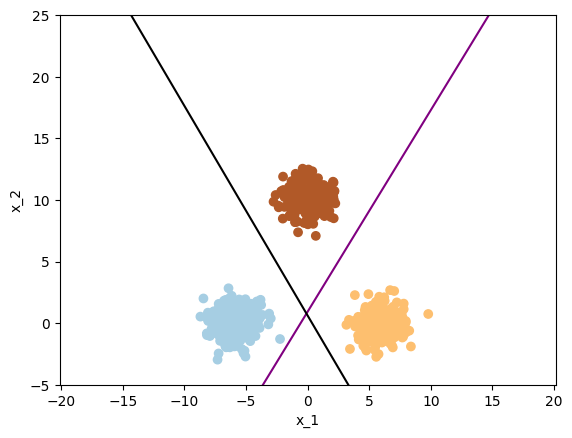

Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=35  Objective=-.136007581205E+01  Residual=-.177635683940E-14
Start stage  1
Ext.iteration=0  Objective=-.150038332746E-15  Residual=-.177635683940E-14
Ext.iteration=32  Objective=-.177458877918E+00  Residual=0.104088654140E-06
Start stage  2
Ext.iteration=0  Objective=-.904694432320E-16  Residual=0.104088654140E-06
Ext.iteration=28  Objective=-.162331289310E-02  Residual=0.177635683940E-14
Start stage  3
Ext.iteration=0  Objective=0.252930280680E-15  Residual=0.177635683940E-14
Ext.iteration=22  Objective=0.252930280680E-15  Residual=0.177635683940E-14
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: obj

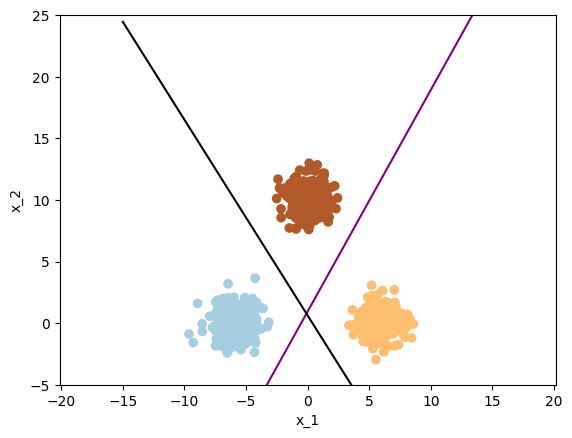

Running solver
Reading problem formulation
Asking for data information
Getting data
     14.3% of scenarios is processed
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=31  Objective=-.153717919219E+01  Residual=0.888178419700E-14
Start stage  1
Ext.iteration=0  Objective=-.444612006339E-15  Residual=0.888178419700E-14
Ext.iteration=36  Objective=-.188199773855E+00  Residual=0.262900812231E-12
Start stage  2
Ext.iteration=0  Objective=-.176862455318E-15  Residual=0.262900812231E-12
Ext.iteration=26  Objective=-.336580944621E-02  Residual=0.177635683940E-14
Start stage  3
Ext.iteration=0  Objective=0.392120718901E-15  Residual=0.177635683940E-14
Ext.iteration=25  Objective=-.252834605826E-04  Residual=0.177990955308E-11
Start stage  4
Ext.iteration=0  Objective=0.520037421341E-16  Residual=0.177990955308E-11
Ext.iteration=19 

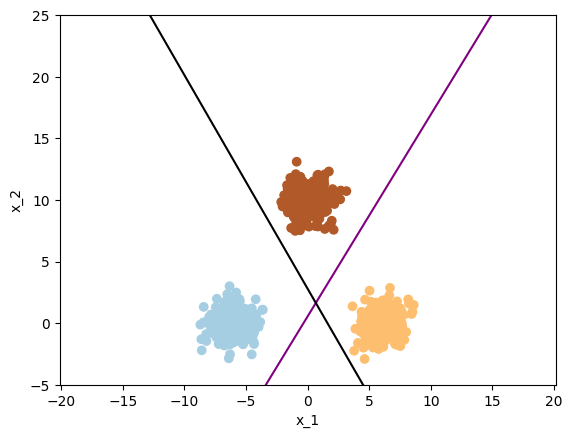

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_scenarios was read
100% of matrix_quadratic1 was read
100% of matrix_quadratic2 was read
Start optimization
Ext.iteration=0  Objective=0.800000000000E+01  Residual=-.800000000000E+01
Ext.iteration=31  Objective=-.139329543178E+01  Residual=0.355271367880E-14
Start stage  1
Ext.iteration=0  Objective=0.645655409965E-16  Residual=0.355271367880E-14
Ext.iteration=28  Objective=-.181522269534E+00  Residual=0.331620189087E-07
Start stage  2
Ext.iteration=0  Objective=-.345260941581E-15  Residual=0.331620189087E-07
Ext.iteration=31  Objective=-.273444241117E-02  Residual=0.239026576310E-10
Start stage  3
Ext.iteration=0  Objective=-.260994877255E-15  Residual=0.239026576310E-10
Ext.iteration=20  Objective=-.260994877255E-15  Residual=0.239026576310E-10
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = 0.119223038696 [0.0000000000

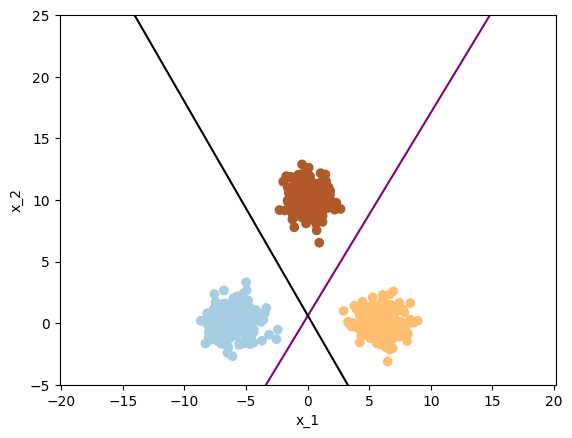

In [10]:
for i in range(10):
  p_tilda, p_star, w_tilda, w_star, a_tilda, a_star, X, y, colors = driver()
  f1 = lambda x: (w_star[2] - w_star[0]*x)/w_star[1]
  f2 = lambda x: (w_star[5] - w_star[3]*x)/w_star[4]
  x_vals = np.linspace(-15, 15, 20)
  y1_vals = f1(x_vals)
  y2_vals = f2(x_vals)
  plt.scatter(colors[0][:, 0], colors[0][:, 1], c=colors[1], cmap=plt.cm.Paired)
  plt.plot(x_vals, y1_vals, c='purple')
  plt.plot(x_vals, y2_vals, c='black')
  plt.xlabel('x_1')
  plt.ylabel('x_2')
  plt.axis('equal')
  plt.xlim(-10, 10)
  plt.ylim(-5, 25)
  plt.show()